# Fraud Detection in Electricity and Gas Consumption - STEG
## Description of the Business Problem
- The Tunisian Company of Electricity and Gas (STEG) is a public and a non-administrative company, it is responsible for delivering electricity and gas across Tunisia. 

- The company suffered tremendous losses in the order of 200 million Tunisian Dinars due to fraudulent manipulations of meters by consumers.

- Using the client’s billing history, we aim to build a model that can detect and recognize clients involved in fraudulent activities.

- The data solution is geared towards enhancing the company’s revenues and reduce the losses caused by such fraudulent activities.

## Pre-Requisites
#### Set up file paths and directories

In [1]:
import os
import zipfile

import os.path
from os import path


DATA_DIR = r'C:\Users\HP\OneDrive\Desktop\Moringa bootcamp\Zindi\Fraud-detection-in-electricity-and-gas-consumption-challenge'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')
OUTPUT_DIR = os.path.join(DATA_DIR, 'output')

# Ensure directories exist
for pth in [TRAIN_DIR, TEST_DIR, OUTPUT_DIR]:
    if not os.path.exists(pth):
        os.mkdir(pth)

# Define ZIP file paths
train_zip_path = os.path.join(TRAIN_DIR, "train.zip")
test_zip_path = os.path.join(TEST_DIR, "test.zip")

# Define sample submission path
sample_sub_path = os.path.join(OUTPUT_DIR,"SampleSubmission.csv")

# Unzip train.zip
if os.path.exists(train_zip_path):
    with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
        zip_ref.extractall(TRAIN_DIR)
else:
    print("train.zip not found at", train_zip_path)

# Unzip test.zip
if os.path.exists(test_zip_path):
    with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
        zip_ref.extractall(TEST_DIR)
else:
    print("test.zip not found at", test_zip_path)

#### Import Libraries

In [2]:
## Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold,cross_val_predict, GridSearchCV
from sklearn.metrics import auc, roc_auc_score,precision_recall_curve,roc_curve, classification_report
from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE # for handling class imbalance
from imblearn.combine import SMOTEENN # for handling class imbalance

# Suppress warnings
import warnings
import joblib

warnings.simplefilter('ignore')

# Reduce joblib verbosity
joblib.parallel_backend('loky', n_jobs=1);  # Avoid triggering subprocess CPU probe


In [3]:
# Read the datasets
client_train = pd.read_csv(f'{TRAIN_DIR}/client_train.csv', low_memory=False)
invoice_train = pd.read_csv(f'{TRAIN_DIR}/invoice_train.csv', low_memory=False)

client_test = pd.read_csv(f'{TEST_DIR}/client_test.csv', low_memory=False)
invoice_test = pd.read_csv(f'{TEST_DIR}/invoice_test.csv', low_memory=False)
sample_submission = pd.read_csv(f'{DATA_DIR}/SampleSubmission.csv', low_memory=False)

## Data Preparation
1) Exploratory Data Analysis (EDA)

2) Feature Engineering


##### Exploratory Data Analysis

In [4]:
# compare size of the various datasets
print(invoice_train.shape, invoice_test.shape, client_train.shape, client_test.shape, )

(4476749, 16) (1939730, 16) (135493, 6) (58069, 5)


In [5]:
# print top rows of dataset (invoice_train)
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [6]:
# print top rows of dataset (client_train)
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [7]:
# Get concise information of each column in dataset
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [8]:
# Get concise information of each column in dataset
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


___
**Finding**: 
- There are column names that need renaming to increase ease of understanding: `disrict`, `consommation_level_1`, `reading_remarque` among others
___

In [9]:
# Rename columns
client_train.rename(columns={'disrict': 'district'}, inplace=True)
client_test.rename(columns={'disrict': 'district'}, inplace=True)

invoice_train.rename(columns={
    'consommation_level_1': 'Consumption_level_1',
    'consommation_level_2': 'Consumption_level_2',
    'consommation_level_3': 'Consumption_level_3',
    'consommation_level_4': 'Consumption_level_4',
    'reading_remarque': 'reading_remarks',
    'tarif_type':'tariff_type' }, inplace=True)

invoice_test.rename(columns={
    'consommation_level_1': 'Consumption_level_1',
    'consommation_level_2': 'Consumption_level_2',
    'consommation_level_3': 'Consumption_level_3',
    'consommation_level_4': 'Consumption_level_4',
    'reading_remarque': 'reading_remarks',
    'tarif_type':'tariff_type' }, inplace=True)

In [10]:
# Getting unique values on the client data
for col in client_train.columns:
    print(f"{col} - {client_train[col].nunique()}",)
print()
for col in client_test.columns:
    print(f"{col} - {client_test[col].nunique()}")

district - 4
client_id - 135493
client_catg - 3
region - 25
creation_date - 8088
target - 2

district - 4
client_id - 58069
client_catg - 3
region - 24
creation_date - 7388


___
**Finding**: 
- There is a mismatch in the number of regions in the client datasets (Train and Test)  - `Region` is an important column thus we need to reconcile the datasets
___

In [11]:
# Drop records in the train dataset with 'Region' feature missing in the test dataset
client_train = client_train[client_train['region'].isin(client_test['region'])]
client_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135491 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   district       135491 non-null  int64  
 1   client_id      135491 non-null  object 
 2   client_catg    135491 non-null  int64  
 3   region         135491 non-null  int64  
 4   creation_date  135491 non-null  object 
 5   target         135491 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 7.2+ MB


In [12]:
# check for missing values
print(invoice_train.isnull().sum())
print()
print(client_train.isnull().sum())

client_id              0
invoice_date           0
tariff_type            0
counter_number         0
counter_statue         0
counter_code           0
reading_remarks        0
counter_coefficient    0
Consumption_level_1    0
Consumption_level_2    0
Consumption_level_3    0
Consumption_level_4    0
old_index              0
new_index              0
months_number          0
counter_type           0
dtype: int64

district         0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64


___
**Finding**: There are no missing values in the train sets for both Client and Invoice data
___

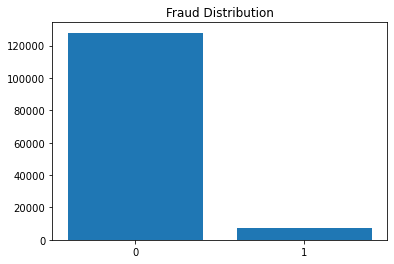

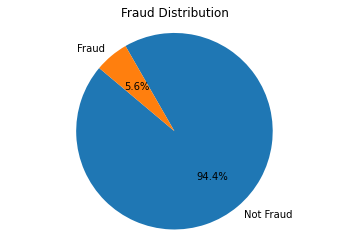

In [13]:
# Visualize Target Distribution (bar chart)
fraud_dist = client_train.groupby(['target'])['client_id'].count()
plt.bar(x=fraud_dist.index, height=fraud_dist.values, tick_label = [0,1])
plt.title('Fraud Distribution')
plt.show();

#Visualize Target Distribution (pie chart)
fraud_dist_2 = client_train['target'].value_counts(normalize=True)
plt.pie(fraud_dist_2, labels=['Not Fraud', 'Fraud'], autopct='%1.1f%%', startangle=140)
plt.title('Fraud Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show();

___
**Finding**: 
- The Target ('Fraud') is highly imbalanced with *5.6%* of client accounts classified as fraudulent while *94.4%* of client accounts classified as not fraudulent.
___

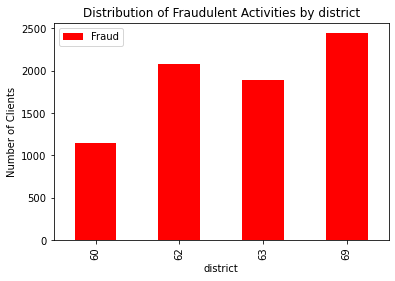

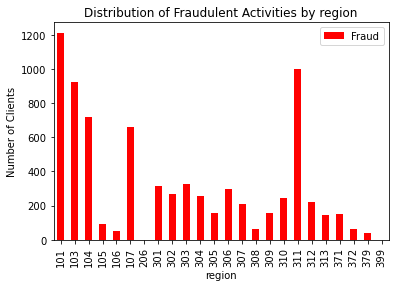

In [14]:
# Visualize Target Distribution across Districts and Regions
for col in ['district', 'region']:
    df = client_train.groupby([col, 'target'])['client_id'].count().unstack()
    df.drop(columns=0, inplace=True)
    df.plot(kind='bar', color='red')
    plt.title(f'Distribution of Fraudulent Activities by {col}')
    plt.xlabel(col)
    plt.ylabel('Number of Clients')
    plt.legend(labels=['Fraud'])
    plt.show();


___
**Findings**: 
- Fraudulent client accounts are reasonably well distributed across regions

- There are a few outlier regions with a much higher number of fraudulent client accounts (101-104, 107,311)
___

#### Feature Engineering

In [15]:
# convert date columns to date time format 
for df in [invoice_train,invoice_test]:
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])

for df in [client_train,client_test]:
    df['creation_date'] = pd.to_datetime(df['creation_date'])



In [16]:
# Compute the average consumption levels and number of transactions for each client

def aggregate_by_client_id(invoice_data):
    aggs = {}
    aggs['Consumption_level_1'] = ['mean']
    aggs['Consumption_level_2'] = ['mean']
    aggs['Consumption_level_3'] = ['mean']
    aggs['Consumption_level_4'] = ['mean']

    # Aggregate the invoice data by client_id
    agg_trans = invoice_data.groupby(['client_id']).agg(aggs)

    # Flatten the MultiIndex columns
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    # Return a dataframe showing number of transactions for each client    
    trans_count = (invoice_data.groupby('client_id')
            .size()
            .reset_index(name='transactions_count'))
    
    # Merge transaction count and mean consumption dataframes  
    return pd.merge(trans_count, agg_trans, on='client_id', how='left')

In [17]:
# Group invoice data by client_id
agg_train = aggregate_by_client_id(invoice_train)
agg_test = aggregate_by_client_id(invoice_test)

# Merge aggregate invoice data with client data
train = pd.merge(client_train,agg_train, on='client_id', how='left')
test = pd.merge(client_test,agg_test, on='client_id', how='left')

In [18]:
train.shape, test.shape

((135491, 11), (58069, 10))

In [19]:
# Encode categorical columns using OneHotEncoder
def encode_categorical_columns(df, columns):
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
    encoded_cols = encoder.fit_transform(df[columns])
    encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(columns))
    df = df.drop(columns=columns)
    return pd.concat([df, encoded_df], axis=1)

In [20]:
# Encode categorical columns
train = encode_categorical_columns(train,['district', 'client_catg', 'region'])
test = encode_categorical_columns(test,['district', 'client_catg', 'region'])

#drop redundant columns
#sub_client_id = test['client_id']
drop_columns = ['client_id', 'creation_date']

for col in drop_columns:
    if col in train.columns:
        train.drop([col], axis=1, inplace=True)
    if col in test.columns:
        test.drop([col], axis=1, inplace=True)


In [21]:

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135491 entries, 0 to 135490
Data columns (total 34 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   target                    135491 non-null  float64
 1   transactions_count        135491 non-null  int64  
 2   Consumption_level_1_mean  135491 non-null  float64
 3   Consumption_level_2_mean  135491 non-null  float64
 4   Consumption_level_3_mean  135491 non-null  float64
 5   Consumption_level_4_mean  135491 non-null  float64
 6   district_62               135491 non-null  float64
 7   district_63               135491 non-null  float64
 8   district_69               135491 non-null  float64
 9   client_catg_12            135491 non-null  float64
 10  client_catg_51            135491 non-null  float64
 11  region_103                135491 non-null  float64
 12  region_104                135491 non-null  float64
 13  region_105                135491 non-null  f

In [22]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58069 entries, 0 to 58068
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   transactions_count        58069 non-null  int64  
 1   Consumption_level_1_mean  58069 non-null  float64
 2   Consumption_level_2_mean  58069 non-null  float64
 3   Consumption_level_3_mean  58069 non-null  float64
 4   Consumption_level_4_mean  58069 non-null  float64
 5   district_62               58069 non-null  float64
 6   district_63               58069 non-null  float64
 7   district_69               58069 non-null  float64
 8   client_catg_12            58069 non-null  float64
 9   client_catg_51            58069 non-null  float64
 10  region_103                58069 non-null  float64
 11  region_104                58069 non-null  float64
 12  region_105                58069 non-null  float64
 13  region_106                58069 non-null  float64
 14  region

## Data Modelling and Evaluation

- We will build 2 baseline models (`Logistic Regression` and `Decision Trees`) to compare both parametric and non-parametric models.

- We will then enhance these models with tuned hyperparameters and possibly introduce a more robust model if deemed necessary



### Train + Evaluate Base Models

In [23]:
# Define the Target and feature variables
X = train.drop(columns=['target'])
y = train['target']

# Split the train dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression Classifier
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)

# Decision Tree Classifier
decision_model = DecisionTreeClassifier(random_state=42)
decision_model.fit(X_train, y_train)


# Predict on the train set
y_pred_log_train = log_model.predict(X_train)
y_probab_log_train = log_model.predict_proba(X_train)[:, 1]

y_pred_decision_train = decision_model.predict(X_train)
y_probab_decision_train = decision_model.predict_proba(X_train)[:, 1]


# Predict on the test set
y_pred_log_test = log_model.predict(X_test)
y_probab_log_test = log_model.predict_proba(X_test)[:, 1]

y_pred_decision_test = decision_model.predict(X_test)
y_probab_decision_test = decision_model.predict_proba(X_test)[:, 1]


# Evaluate the classifiers
def evaluate_model(y_train, y_test, y_pred_train,y_pred_test,y_probab_train,y_probab_test, model_name):
    print(f"Evaluation for {model_name} Model:")
    print("-"*60)
    print("Classification Report (train):")
    print(classification_report(y_train, y_pred_train))
    print("ROC-AUC Score(train):", roc_auc_score(y_train, y_probab_train))
    print("-"*60)
    print("Classification Report (test):")
    print(classification_report(y_test, y_pred_test))
    print("ROC-AUC Score(test):", roc_auc_score(y_test, y_probab_test))
    print("_"*60)


evaluate_model(y_train, y_test, y_pred_log_train,y_pred_log_test,y_probab_log_train,y_probab_log_test,model_name= "Logistic Regression")
evaluate_model(y_train, y_test, y_pred_decision_train,y_pred_decision_test,y_probab_decision_train,y_probab_decision_test, model_name= "Decision Tree")



Evaluation for Logistic Regression Model:
------------------------------------------------------------
Classification Report (train):
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97    102377
         1.0       0.26      0.00      0.01      6015

    accuracy                           0.94    108392
   macro avg       0.60      0.50      0.49    108392
weighted avg       0.91      0.94      0.92    108392

ROC-AUC Score(train): 0.6852343080130762
------------------------------------------------------------
Classification Report (test):
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     25548
         1.0       0.23      0.00      0.01      1551

    accuracy                           0.94     27099
   macro avg       0.59      0.50      0.49     27099
weighted avg       0.90      0.94      0.92     27099

ROC-AUC Score(test): 0.6898968927353545
________________________________________

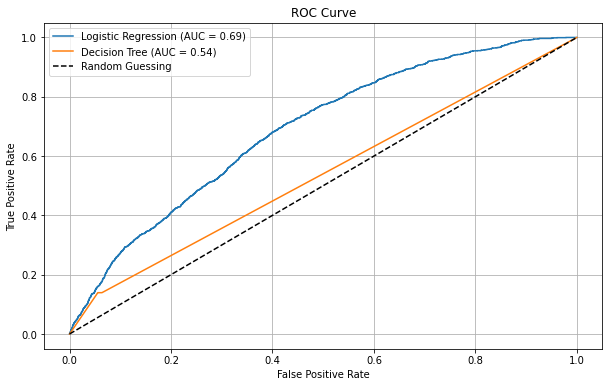

In [24]:
# Plot ROC curves for both models
def plot_roc_curve(y_test, y_probab_log_test, y_probab_decision_test):
    fpr_log, tpr_log, _ = roc_curve(y_test, y_probab_log_test)
    fpr_decision, tpr_decision, _ = roc_curve(y_test, y_probab_decision_test)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr_log, tpr_log, label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_score(y_test, y_probab_log_test)))
    plt.plot(fpr_decision, tpr_decision, label='Decision Tree (AUC = {:.2f})'.format(roc_auc_score(y_test, y_probab_decision_test)))
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid()
    plt.show();

plot_roc_curve(y_test, y_probab_log_test, y_probab_decision_test)

#### Summary findings on the Untuned Models
___
**Logistic Regression**
- The following are the summary metrics for the model:
    - Train and Test Accuracy scores of **~94%**
    - Recall and F1 score of **0-1%** on test data for the minority class (Class 1: Fraud)
    - AUC Score of **~68%** on both test and training data

- These results indicate that the logistic regression model is performing extremely poorly in detecting fraud (Class 1) with a recall score of *zero*. 
- Accuracy scores are extremely misleading (***94%***) which results from us dealing with a highly imbalanced dataset
- The model performs much better than a random model with stable generalization (***AUC: ~68%*** for both train and test data sets indicating *low overfitting*) 

___
**Decision Tree**
- The following are the summary metrics for the model:
    - Train Accuracy of **100%** and Test Accuracy of **~90%**
    - Recall and F1 score of **13-14%** on test data for the minority class 
    - AUC score of **~100%** on training data (near-perfect model) and **~54%** on test data (slightly better than random) 
- These results indicate classic *overfitting* (*Accuracy/AUC: 100%*) on the training dataset with the model basically memorizing the training data
- The model fails to generalize to the test data and barely performs better than a random model (*ROC-AUC: ~54%*)
- These results also indicate a highly imbalanced dataset.
___
**Logistic vs Decision Tree**
- The ROC curve indicates that the logistic regression model outperforms the decision tree model in terms of making correct classifications

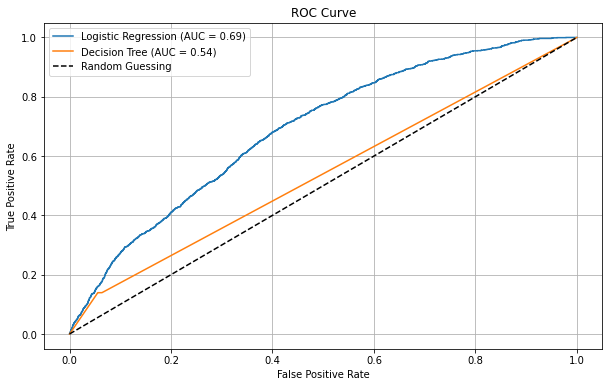

***Summary statistics***:

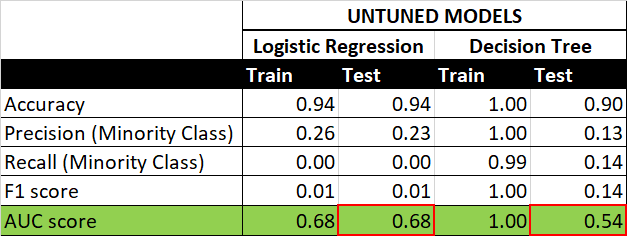

___
**Next Steps: Dealing with Class imbalance + Hyperparameter tuning**

- To deal with class imbalance and improve model performance, we will do the following:

    1) Use the `precision-recall curve` to find ***better classification thresholds*** (default=0.5 is rarely optimal on imbalanced data)

    2) Use class weights in our models by adding a new field `class_weight = 'balanced'`

    3) Apply oversampling/undersampling techniques on the minority/majority class (**SMOTE**/**SMOTEEN**)

    4) Apply stratified sampling techniques (**k-fold Cross-validation**)
    
    6) Use a better model to deal with class imbalance: **XGBoost**

### Train + Evaluate Tuned Models
#### Pipeline 1: Manual Resampling

In [25]:
# 1. Define the Target and feature variables
X = train.drop(columns=['target'])
y = train['target']

# 2. Split the train dataset
# Stratify the split to maintain class diversity in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 3. Scaling the features - important for models like Logistic Regression and XGBoost
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Handle class imbalance with SMOTEEN (random under-sampling + SMOTE over-sampling)
smote = SMOTEENN(random_state=42) # Combination of SMOTE and Edited Nearest Neighbors
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# After resampling
scale_pos_weight = y_train_resampled.value_counts()[0] / y_train_resampled.value_counts()[1]
print(f"Scale Pos Weight: {scale_pos_weight}")

  File "C:\Users\HP\anaconda3\envs\learn-env\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\HP\anaconda3\envs\learn-env\lib\subprocess.py", line 489, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\HP\anaconda3\envs\learn-env\lib\subprocess.py", line 854, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\HP\anaconda3\envs\learn-env\lib\subprocess.py", line 1307, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


Scale Pos Weight: 0.8577078935235738


___
**Finding:**
- Since our `scale_pos_weight = 0.85` after resampling, this means that our classes are mostly balanced (with the minority class slightly overrepresented)
___

##### Train all models on resampled training data

In [26]:
# 5. Train Logistic Regression (with class weights, scaling and SMOTE)
log_model = LogisticRegression(class_weight='balanced', random_state=42)
log_model.fit(X_train_resampled, y_train_resampled)

# 6. Train Decision Tree (with class weights, scaling, SMOTE and tuned hyperparameters)
decision_model = DecisionTreeClassifier(class_weight='balanced', max_depth=10, min_samples_leaf=5, random_state=42)
decision_model.fit(X_train_resampled, y_train_resampled)

# 7. Train XGBoost (with class weights, scaling and SMOTE)
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)

# 8. Find better classification thresholds
best_thresholds_dict = {}

for name, y_probab in [("Logistic Regression", log_model.predict_proba(X_test_scaled)[:, 1]),
                    ("Decision Tree", decision_model.predict_proba(X_test_scaled)[:, 1]),
                    ("XGBoost", xgb_model.predict_proba(X_test_scaled)[:, 1])]:
    
    

    # Calculate precision, recall, and thresholds
    prec, rec, thresholds = precision_recall_curve(y_test, y_probab)
    
    f1_scores = 2 * (prec * rec) / (prec + rec + 1e-10)
    best_idx = f1_scores.argmax()
    best_threshold = thresholds[best_idx]

    best_thresholds_dict[name] = round(best_threshold,3)

best_thresholds_dict

# 9. Evaluate all the models

for name, model in [("Logistic Regression", log_model),
                    ("Decision Tree", decision_model),
                    ("XGBoost", xgb_model)]:
    print("_"*80)
    print(f"Evaluation for {name} Model:")
    print("_"*80)

    # Function to apply a threshold to predicted probabilities
    threshold = best_thresholds_dict[name]

    def apply_threshold(y_proba, threshold):
        return (y_proba > threshold).astype(int)
    
    # Cross-validation setup
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Loop through train and test sets for evaluation
    for label, X_eval, y_eval in [("train", X_train_resampled, y_train_resampled),
                                  ("test", X_test_scaled, y_test)]:
        
        # Predict on the evaluation set
        #y_pred = model.predict(X_eval)
        y_probab = model.predict_proba(X_eval)[:, 1]
        y_pred = apply_threshold(y_probab, threshold)

        # Perform cross-validation
        cv_scores = cross_val_score(model, X_eval, y_eval, cv=cv, scoring='roc_auc')
        
        # Print classification report and ROC-AUC score
        print("-"*80)
        print(f"Classification Report ({label}):")
        print("-"*80)
        print(classification_report(y_eval, y_pred))
        print("-"*80)
        print(f"ROC-AUC Score ({label}): {roc_auc_score(y_eval, y_probab):.3f}")
        print(f"Cross-Validated ROC-AUC Scores ({label}): {cv_scores}")
        print(f"Mean Cross-Validated ROC-AUC Score ({label}): {np.mean(cv_scores):.3f}")
        


________________________________________________________________________________
Evaluation for Logistic Regression Model:
________________________________________________________________________________
--------------------------------------------------------------------------------
Classification Report (train):
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.55      0.89      0.68     70694
         1.0       0.80      0.37      0.51     82422

    accuracy                           0.61    153116
   macro avg       0.67      0.63      0.59    153116
weighted avg       0.68      0.61      0.59    153116

--------------------------------------------------------------------------------
ROC-AUC Score (train): 0.776
Cross-Validated ROC-AUC Scores (train): [0.76986881 0.7814549  0.77846086 0.77670168 0.773     ]
Mean Cross-Validated ROC-AUC Score (train): 0.776
-------------------

___
- In our first pipeline, we carry out resampling (using SMOTEENN) once before model training. SMOTE also uses full training data

- This comes with a risk of data leakage and inflated performance on the training set as seen in the table below

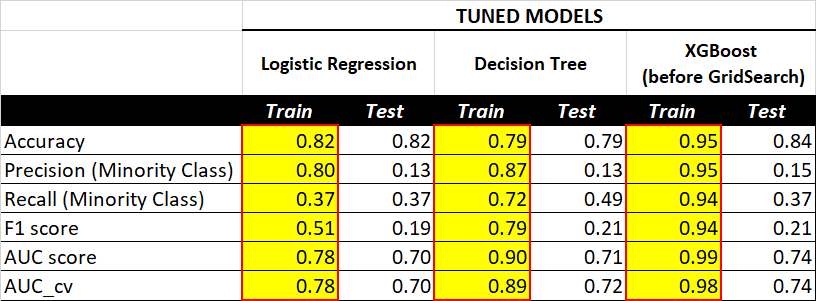

- As a result of this data leakage, later evaluation (cross validation) is not honest and the Train/Test gap is very wide (poor generalization)

#### Pipeline 2: Using `ImbPipeline`
- To mitigate this issue of inflated model performance, we can build our pipeline using `ImbPipeline` which allows us to do the following: 

    a) Apply SMOTEENN within each CV fold

    b) Apply SMOTE only within each training fold - meaning no leakage from the validation set into synthetic data

In [27]:
# 1. Define target and features
X = train.drop(columns=['target'])
y = train['target']

# 2. Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 3. Define models
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', max_depth=10, min_samples_leaf=5, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}

# 4. Define threshold per model (from previous tuning)
best_thresholds = {
    "Logistic Regression": 0.697,
    "Decision Tree": 0.661,
    "XGBoost": 0.545
    }

# 5. Setup cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 6. Evaluation function
def evaluate_model(name, model, threshold):
    print("="*80)
    print(f"Evaluating: {name}")
    print("="*80)

    # Create pipeline: Scaling + SMOTE + Model
    pipe = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smoteen', SMOTEENN(random_state=42)),
        ('model', model)
    ])

    # Fit pipeline on training data
    pipe.fit(X_train, y_train)

    # Predict probabilities on train and test sets
    for label, X_eval, y_eval in [("Train", X_train, y_train), ("Test", X_test, y_test)]:
        y_proba = pipe.predict_proba(X_eval)[:, 1]
        y_pred = (y_proba > threshold).astype(int)

        print(f"Classification Report ({label}):")
        print("-"*80)
        print(classification_report(y_eval, y_pred))
        print(f"AUC Score ({label}): {roc_auc_score(y_eval, y_proba):.3f}")
        print("-"*80)
        
    # Cross-validated AUC
    y_cv_proba = cross_val_predict(pipe, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
    y_cv_pred = (y_cv_proba > threshold).astype(int)

    print(f"Cross-Validated AUC Score: {roc_auc_score(y_train, y_cv_proba):.3f}")
    print("="*80)

# 7. Run evaluation for each model
for name, model in models.items():
    threshold = best_thresholds[name]
    evaluate_model(name, model, threshold)


Evaluating: Logistic Regression
Classification Report (Train):
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.85      0.90    102339
         1.0       0.12      0.35      0.18      6053

    accuracy                           0.82    108392
   macro avg       0.54      0.60      0.54    108392
weighted avg       0.91      0.82      0.86    108392

AUC Score (Train): 0.701
--------------------------------------------------------------------------------
Classification Report (Test):
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.85      0.90     25586
         1.0       0.13      0.37      0.19      1513

    accuracy                           0.82     27099
   macro avg       0.54      0.61      0.54     27099
weighted avg       0.91      0.82      0

___
- Model results from Pipeline 2 thus end up looking like this:

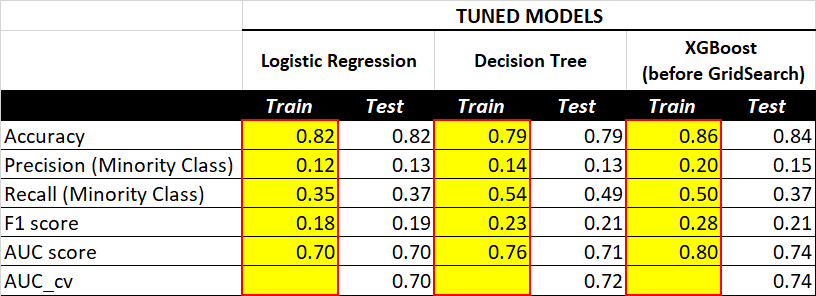

- We can see that this pipeline gives a truer picture of model performance on the training dataset - the Train/Test gap is less wide making the model more reliable (great generalization)

##### Choosing the best-performing model

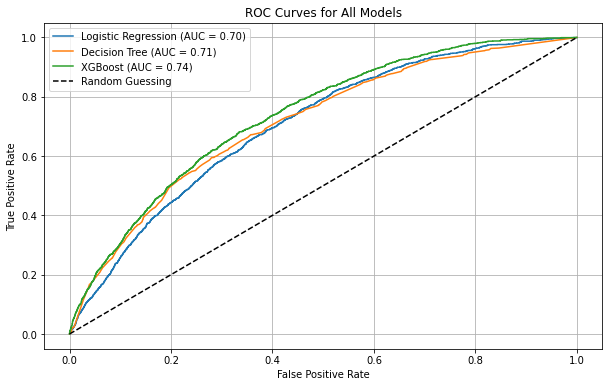

In [28]:
# Plot the ROC curves for all models
def plot_roc_curves(models, X_test_scaled, y_test):
    plt.figure(figsize=(10, 6))
    
    for name, model in models.items():
        y_probab = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_probab)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_probab):.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Models')
    plt.legend()
    plt.grid()
    plt.show();

# Define the models to plot
models_to_plot = {
    "Logistic Regression": log_model,
    "Decision Tree": decision_model,
    "XGBoost": xgb_model
}   

# Plot the ROC curves
plot_roc_curves(models_to_plot, X_test_scaled, y_test)

#### Summary Findings on the Tuned Models (Pipeline 2)
___
**Logistic Regression (Tuned)**
- The following are the summary metrics for the tuned model:
    - Train/Test Accuracy: **82%**
    - Recall: **37%**, F1 score: **19%** - on test data for the minority class (Class 1: Fraud)
    - AUC Score: **70%** on test data

- The tuned model shows a significant increase in performance on all metrics: recall (increase of ***36%***), F1 score (increase of ***18%***) 

___
**Decision Tree (Tuned)**
- The following are the summary metrics for the tuned model:
    - Train/Test Accuracy: **79%**
    - Recall: **49%**, F1 score: **21%** - on test data for the minority class (Class 1: Fraud)
    - AUC Score: **71%** on test data

- The tuned model shows a significant increase in performance on all metrics when compared to the base models: recall (increase of ***35%***), F1 score (increase of ***7%***) 
___
**XGBoost (Tuned)**
- The following are the summary metrics for the tuned model:
    - Train Accuracy: **86%**, Test Accuracy: **84%**
    - Recall: **37%**, F1 score: **21%** - on test data for the minority class (Class 1: Fraud)
    - AUC Score: **74%** on test data

- As per the ROC curves, `XGBoost` outperforms all other models in terms of predictive power (`AUC = 0.74`)

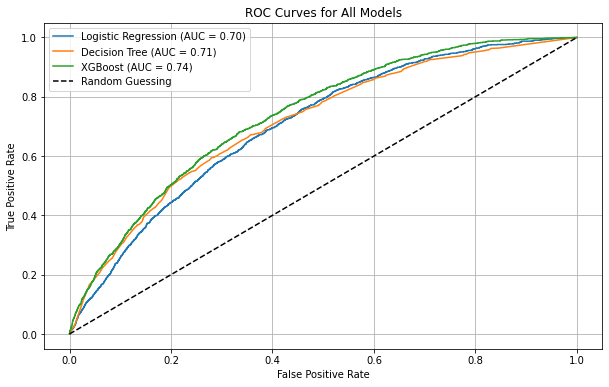

- In terms of the other classification metrics (accuracy, F1-score), `XGBoost` also marginally outperforms other models (1st in accuracy, 1st in F1 score)


***Summary statistics***

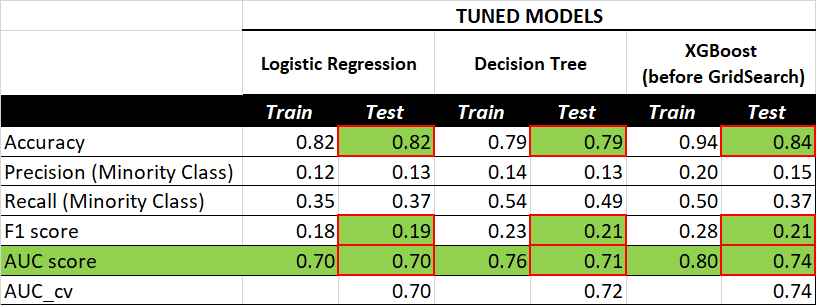



#### Using `GridSearchCV` on XGBoost (further tuning)

In [29]:
# 1. Define target and features
X = train.drop(columns=['target'])
y = train['target']

# 2. Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 3. Define models and their parameter grids
model_grids = {
    "XGBoost": {
        "model": XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
        "params": {
            'model__n_estimators': [100],
            'model__max_depth': [3, 5, 7],
            'model__scale_pos_weight': [1, 2, 5]  # adjust based on class imbalance ratio
        }
    }
}

# 4. Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5. Helper: find best threshold based on F1
def find_best_threshold(y_true, y_prob):
    prec, rec, thresholds = precision_recall_curve(y_true, y_prob)
    f1 = 2 * (prec * rec) / (prec + rec + 1e-10)
    best_idx = np.argmax(f1)
    return thresholds[best_idx], f1[best_idx]

# 6. Main evaluation loop
for name, config in model_grids.items():
    print("="*100)
    print(f"Running GridSearchCV for: {name}")
    print("="*100)

    # Build pipeline: scaler + SMOTE + model
    pipe = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smoteen', SMOTEENN(random_state=42)),
        ('model', config['model'])
    ])

    # Grid search
    grid = GridSearchCV(pipe, config['params'], scoring='roc_auc', cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)

    print(f"Best Parameters: {grid.best_params_}")
    print(f"Best Cross-Validated AUC: {grid.best_score_:.3f}")

    # Evaluate on test set
    best_model = grid.best_estimator_

    # Predict probabilities
    y_test_proba = best_model.predict_proba(X_test)[:, 1]
    y_train_proba = best_model.predict_proba(X_train)[:, 1]

    # Find optimal threshold on training data
    threshold, best_f1 = find_best_threshold(y_train, y_train_proba)
    print(f"Best F1 Threshold (train): {threshold:.3f} (F1: {best_f1:.3f})")

    # Apply threshold
    y_test_pred = (y_test_proba > threshold).astype(int)

    # Report
    print("\nTest Classification Report:")
    print(classification_report(y_test, y_test_pred))
    print(f"Test ROC-AUC: {roc_auc_score(y_test, y_test_proba):.3f}")

    print("="*100 + "\n")


Running GridSearchCV for: XGBoost
[02:04:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Best Parameters: {'model__max_depth': 3, 'model__n_estimators': 100, 'model__scale_pos_weight': 1}
Best Cross-Validated AUC: 0.739
Best F1 Threshold (train): 0.714 (F1: 0.228)

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.87      0.92     25586
         1.0       0.15      0.39      0.22      1513

    accuracy                           0.85     27099
   macro avg       0.56      0.63      0.57     27099
weighted avg       0.92      0.85      0.88     27099

Test ROC-AUC: 0.742



In [33]:
# Predict probabilities
y_train_proba = best_model.predict_proba(X_train)[:, 1]

# Apply threshold
y_train_pred = (y_train_proba > threshold).astype(int)

# Report
print("\nTrain Classification Report:")
print(classification_report(y_train, y_train_pred))
print(f"Train ROC-AUC: {roc_auc_score(y_train, y_train_proba):.3f}")

print("="*100 + "\n")


Train Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.87      0.92    102339
         1.0       0.16      0.41      0.23      6053

    accuracy                           0.85    108392
   macro avg       0.56      0.64      0.57    108392
weighted avg       0.92      0.85      0.88    108392

Train ROC-AUC: 0.755



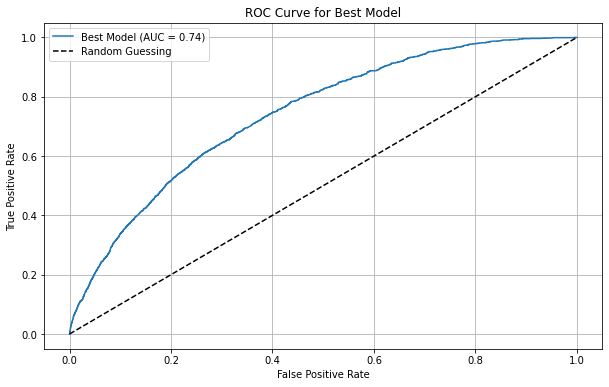

In [30]:
# Plot the ROC curve for the best model
def plot_best_model_roc_curve(best_model, X_test, y_test):
    y_probab = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probab)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'Best Model (AUC = {roc_auc_score(y_test, y_probab):.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Best Model')
    plt.legend()
    plt.grid()
    plt.show();

# Plot ROC curve for the best model
best_model = grid.best_estimator_
plot_best_model_roc_curve(best_model, X_test, y_test)


#### Summary Findings on the Best Model (Tuned XGBoost)

- The following are the summary metrics for XGBoost tuned via GridSearchCV:

    - Train/Test Accuracy: **85%**
    
    - Recall: **39%**, F1 score: **22%** - on test data for the minority class (Class 1: Fraud)
    
    - AUC Score: **74%** on test data
    
    - As per the ROC curve, XGBoost tuned via GridSearchCV also has an `AUC = 0.74`
    
    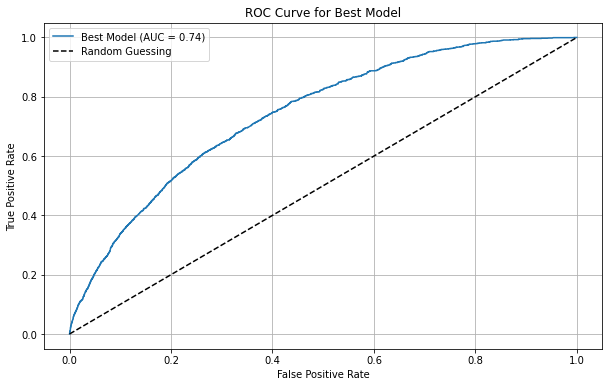
    
***Summary Statistics***

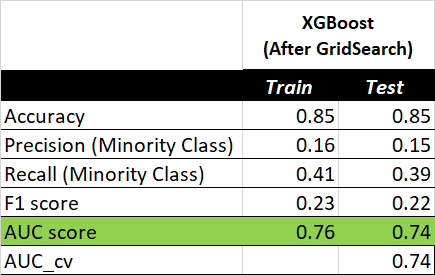

## Conclusion and Next Steps

#### Conclusions

- The model with the highest predictive power/performance is:
    - Name: **Tuned XGBoost** 
    
    - Tuning technique: **GridSearchCV**
    
    - Best Model (ROC)AUC Score: **74%**
    
    - Best Model F1 Score: **22%**

#### Next Steps: 

- **Feature transparency**: Identify the top features most predictive of fraud using SHAP: region or district? Consumption threshold? 

- Incorporate Precision-Recall AUC (better than ROC AUC for imbalance)

- Deploy the model onto the client systems
 